<a href="https://colab.research.google.com/github/gguex/ISH_ressources_cours_ML/blob/main/TP05_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP 5 : clustering

Dans ce TP, nous allons mettre en oeuvre les trois méthodes de clustering vues en cours sur le jeux de données des vins italiens (wine.data).

Il n'y a pas d'exercice pour cette semaine, concentrez-vous sur votre rendu !

Les librairies et modules nécessaires sont


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Pour modifier la taille de sortie de graphiques dans le notebook
plt.rcParams['figure.figsize'] = [12, 12]
# Pour le traitement des données
from sklearn.preprocessing import StandardScaler
# Les méthodes de clustering effectuées
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
# Nos différentes mesures
from sklearn.metrics import calinski_harabasz_score, adjusted_rand_score, \
  adjusted_mutual_info_score, homogeneity_score, completeness_score

Comme précédemment, on charge les données, on isole la sortie et on standardise les entrées

In [2]:
# On charge les données
file_path = "drive/MyDrive/Colab Notebooks/ml_data/TP5/wine.data"
data = pd.read_csv(file_path, header=None)
# On standardise et sauve les entrées
inputs = StandardScaler().fit_transform(data.drop([0], axis=1))
# On sauve les sorties
outputs = data[0]

Il n'existe malheureusement pas de fonction pour calculer l'inertie intra-groupe dans `sklearn`. Nous allons donc créer cette fonction

In [3]:
def inertia_score(X, labels):
  # On liste les différents groupes
  groups = set(labels)
  # Un vecteur vide contenant les résidus au carré
  sq_residuals = np.repeat(0, X.shape[0])
  # On boucle sur les groupes
  for group in groups:
    # On restraint notre matrice de données au points du groupe
    X_g = np.array(X)[labels == group, :]
    # On calcule les coordonnées centrées
    std_scale = StandardScaler(with_std=False)
    # On calcule les résidus au carré
    sq_residuals_g = (std_scale.fit_transform(X_g)**2).sum(axis=1)
    # On le sauve dans notre vecteur
    sq_residuals[labels == group] = sq_residuals_g
  # On retourne la somme des rédidus au carré
  return sum(sq_residuals)

Pour le clustering sans réponse, il n'y a pas besoin de faire une cross-validation car il n'y a aucun risque de surparamétrisation.

En revanche, si nos algorithmes contenaient des hyperparmètres (autre que $k$, qui se déduit immédiatement avec un jeu d'entrainement) et que nous désirerions les optimiser via une mesure extrinsèque, la séparation des données entre jeux d'entrainement et test est encore pertinente. En effet, nous pourrions optimiser les hyperparmètres sur un jeu d'entrainement en utilisant la mesure extrinsèque, puis tester le modèle retenu sur le jeu de test. Cette procédure n'est pourtant pas valable pour toutes les méthodes (p.ex. elle ne fonctionne pas avec les clusterings hiérarchiques).

Ici, nous faisons simplement une boucle sur tous les $k$, puis un certain nombre de clusterings (pour minimiser l'effet de la chance) et sauvons les valeurs moyennes et écart-types de nos deux mesures (`inertia_score` et `calinski_harabasz_score`).

In [4]:
# Liste pour le nombre de groupes à tester
k_pars = list(range(2, 13))
# Nombre de tests à effectuer
n_test = 5

# Les vecteurs pour les scores moyens
kms_in_mscores, kms_ch_mscores = np.zeros_like(k_pars), np.zeros_like(k_pars)
hac_in_mscores, hac_ch_mscores = np.zeros_like(k_pars), np.zeros_like(k_pars)
gmm_in_mscores, gmm_ch_mscores = np.zeros_like(k_pars), np.zeros_like(k_pars)
# Les vecteurs pour les deviation
kms_in_sscores, kms_ch_sscores = np.zeros_like(k_pars), np.zeros_like(k_pars)
hac_in_sscores, hac_ch_sscores = np.zeros_like(k_pars), np.zeros_like(k_pars)
gmm_in_sscores, gmm_ch_sscores = np.zeros_like(k_pars), np.zeros_like(k_pars)

# Boucle sur le nombre de groupes
for i, k in enumerate(k_pars):

  # Pour sauver les différents score
  kms_in_scores, kms_ch_scores = np.zeros(n_test), np.zeros(n_test)
  hac_in_scores, hac_ch_scores = np.zeros(n_test), np.zeros(n_test)
  gmm_in_scores, gmm_ch_scores = np.zeros(n_test), np.zeros(n_test)

  # On fait un certain nombre d'essais
  for j in range(n_test):

    # On entraine et prédit les labels
    kms_labels = KMeans(n_clusters=k, n_init="auto").fit_predict(inputs)
    hac_labels = AgglomerativeClustering(n_clusters=k).fit_predict(inputs)
    gmm_labels = GaussianMixture(n_components=k).fit_predict(inputs)
    # On sauve les scores
    kms_in_scores[j] = inertia_score(inputs, kms_labels)
    hac_in_scores[j] = inertia_score(inputs, hac_labels)
    gmm_in_scores[j] = inertia_score(inputs, gmm_labels)
    kms_ch_scores[j] = calinski_harabasz_score(inputs, kms_labels)
    hac_ch_scores[j] = calinski_harabasz_score(inputs, hac_labels)
    gmm_ch_scores[j] = calinski_harabasz_score(inputs, gmm_labels)

  # On sauve la moyenne dans nos vecteurs de scores moyens
  kms_in_mscores[i] = np.mean(kms_in_scores)
  hac_in_mscores[i] = np.mean(hac_in_scores)
  gmm_in_mscores[i] = np.mean(gmm_in_scores)
  kms_ch_mscores[i] = np.mean(kms_ch_scores)
  hac_ch_mscores[i] = np.mean(hac_ch_scores)
  gmm_ch_mscores[i] = np.mean(gmm_ch_scores)
  # On sauve la déviation dans nos vecteurs de scores moyens
  kms_in_sscores[i] = np.std(kms_in_scores)
  hac_in_sscores[i] = np.std(hac_in_scores)
  gmm_in_sscores[i] = np.std(gmm_in_scores)
  kms_ch_sscores[i] = np.std(kms_ch_scores)
  hac_ch_sscores[i] = np.std(hac_ch_scores)
  gmm_ch_sscores[i] = np.std(gmm_ch_scores)

On peut maintenant regarder les courbes de ces différents scores moyens et des déviations.

[]

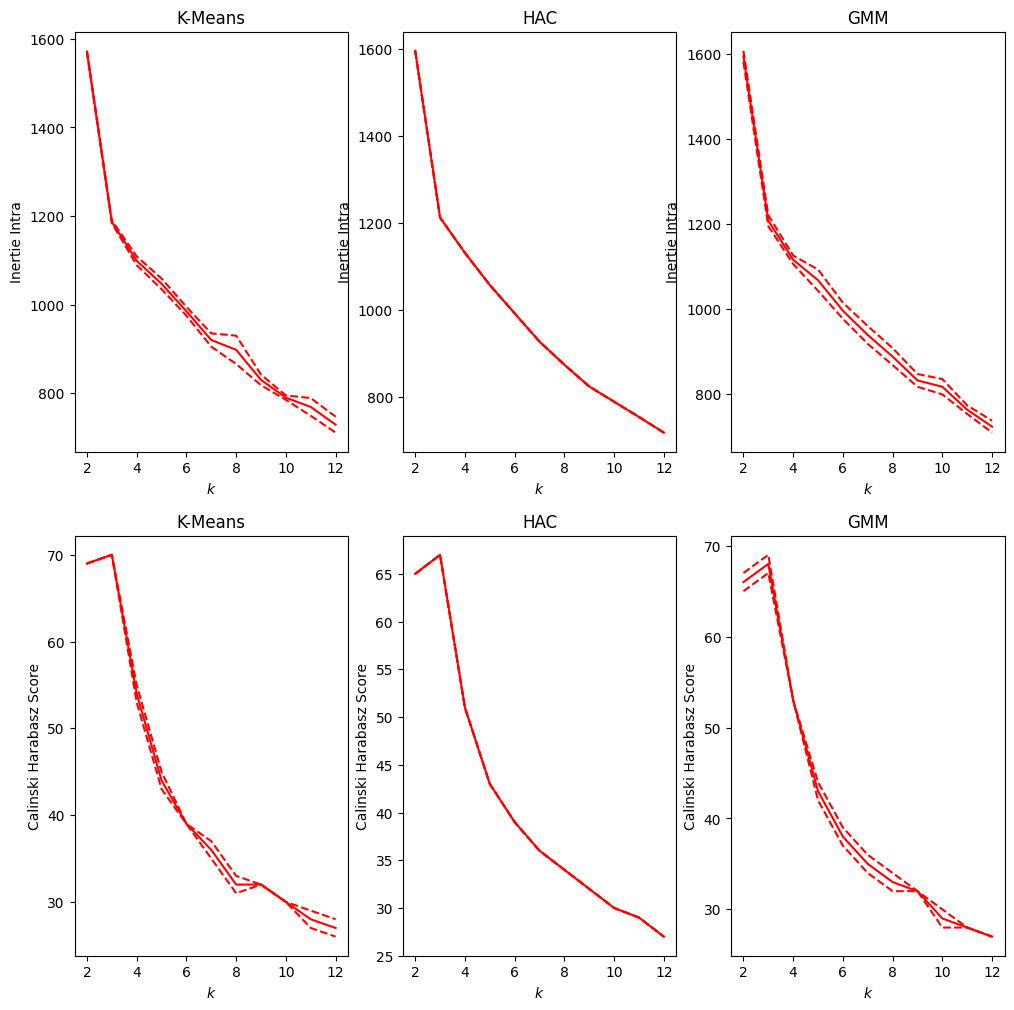

In [5]:
# Plot des différents scores
fig, axs = plt.subplots(2, 3)
# Plot inertie K-means
axs[0, 0].plot(k_pars, kms_in_mscores, c="red")
axs[0, 0].plot(k_pars, kms_in_mscores + kms_in_sscores, c="red", linestyle = "--")
axs[0, 0].plot(k_pars, kms_in_mscores - kms_in_sscores, c="red", linestyle = "--")
axs[0, 0].set_xlabel("$k$")
axs[0, 0].set_ylabel("Inertie Intra")
axs[0, 0].set_title("K-Means")
# Plot inertie HAC
axs[0, 1].plot(k_pars, hac_in_mscores, c="red")
axs[0, 1].plot(k_pars, hac_in_mscores + hac_in_sscores, c="red", linestyle = "--")
axs[0, 1].plot(k_pars, hac_in_mscores - hac_in_sscores, c="red", linestyle = "--")
axs[0, 1].set_xlabel("$k$")
axs[0, 1].set_ylabel("Inertie Intra")
axs[0, 1].set_title("HAC")
# Plot inertie GMM
axs[0, 2].plot(k_pars, gmm_in_mscores, c="red")
axs[0, 2].plot(k_pars, gmm_in_mscores + gmm_in_sscores, c="red", linestyle = "--")
axs[0, 2].plot(k_pars, gmm_in_mscores - gmm_in_sscores, c="red", linestyle = "--")
axs[0, 2].set_xlabel("$k$")
axs[0, 2].set_ylabel("Inertie Intra")
axs[0, 2].set_title("GMM")
# Plot calinski harabasz K-means
axs[1, 0].plot(k_pars, kms_ch_mscores, c="red")
axs[1, 0].plot(k_pars, kms_ch_mscores + kms_ch_sscores, c="red", linestyle = "--")
axs[1, 0].plot(k_pars, kms_ch_mscores - kms_ch_sscores, c="red", linestyle = "--")
axs[1, 0].set_xlabel("$k$")
axs[1, 0].set_ylabel("Calinski Harabasz Score")
axs[1, 0].set_title("K-Means")
# Plot calinski harabasz HAC
axs[1, 1].plot(k_pars, hac_ch_mscores, c="red")
axs[1, 1].plot(k_pars, hac_ch_mscores + hac_ch_sscores, c="red", linestyle = "--")
axs[1, 1].plot(k_pars, hac_ch_mscores - hac_ch_sscores, c="red", linestyle = "--")
axs[1, 1].set_xlabel("$k$")
axs[1, 1].set_ylabel("Calinski Harabasz Score")
axs[1, 1].set_title("HAC")
# Plot calinski harabasz GMM
axs[1, 2].plot(k_pars, gmm_ch_mscores, c="red")
axs[1, 2].plot(k_pars, gmm_ch_mscores + gmm_ch_sscores, c="red", linestyle = "--")
axs[1, 2].plot(k_pars, gmm_ch_mscores - gmm_ch_sscores, c="red", linestyle = "--")
axs[1, 2].set_xlabel("$k$")
axs[1, 2].set_ylabel("Calinski Harabasz Score")
axs[1, 2].set_title("GMM")
plt.plot()

Selon nos critères, nous pouvons retenir le nombre de groupes qui nous semble adapté. On va maintenant comparer ces méthodes avec les vrais données.

In [6]:
# On pose les "meilleurs" k
kms_best_k = 3
hac_best_k = 3
gmm_best_k = 3

# On entraine et prédit les labels
kms_labels = KMeans(n_clusters=kms_best_k, n_init="auto").fit_predict(inputs)
hac_labels = AgglomerativeClustering(n_clusters=hac_best_k).fit_predict(inputs)
gmm_labels = GaussianMixture(n_components=gmm_best_k).fit_predict(inputs)

# On calcule les différentes mesures
kms_ari = adjusted_rand_score(outputs, kms_labels)
hac_ari = adjusted_rand_score(outputs, hac_labels)
gmm_ari = adjusted_rand_score(outputs, gmm_labels)
kms_ami = adjusted_mutual_info_score(outputs, kms_labels)
hac_ami = adjusted_mutual_info_score(outputs, hac_labels)
gmm_ami = adjusted_mutual_info_score(outputs, gmm_labels)
kms_homog = homogeneity_score(outputs, kms_labels)
hac_homog = homogeneity_score(outputs, hac_labels)
gmm_homog = homogeneity_score(outputs, gmm_labels)
kms_comp = completeness_score(outputs, kms_labels)
hac_comp = completeness_score(outputs, hac_labels)
gmm_comp = completeness_score(outputs, gmm_labels)

# On affiche les résultats
print(f"Kmeans k={kms_best_k} : ARI ={kms_ari: .2%}, "
      f"AMI ={kms_ami: .2%}, Homogeneity ={kms_homog: .2%}, "
      f"Completeness ={kms_comp: .2%}")
print(f"HAC k={hac_best_k} : ARI ={hac_ari: .2%}, "
      f"AMI ={hac_ami: .2%}, Homogeneity ={hac_homog: .2%}, "
      f"Completeness ={hac_comp: .2%}")
print(f"GMM k={gmm_best_k} : ARI ={gmm_ari: .2%}, "
      f"AMI ={gmm_ami: .2%}, Homogeneity ={gmm_homog: .2%}, "
      f"Completeness ={gmm_comp: .2%}")

Kmeans k=3 : ARI = 88.04%, AMI = 85.95%, Homogeneity = 86.39%, Completeness = 85.80%
HAC k=3 : ARI = 78.99%, AMI = 78.42%, Homogeneity = 79.04%, Completeness = 78.25%
GMM k=3 : ARI = 88.04%, AMI = 85.95%, Homogeneity = 86.39%, Completeness = 85.80%
